In [1]:
# Common initialisation, constants, etc.

import os.path
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=8)
plt.rc('figure', dpi=200)
plt.rc('axes', axisbelow=True, titlesize=5)
plt.rc('lines', linewidth=1)
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.animation import FuncAnimation

rcparams = {
    'axes.labelsize':6,
    'axes.titlesize':7,
    'font.size':6,
    'legend.fontsize':6,
    'xtick.labelsize':6,
    'ytick.labelsize':6,
    'text.usetex': False,
    'figure.figsize': [3.5, 3.5]    
}

plt.rcParams.update(rcparams)

# font = {'family':'serif', 'color':'black', 'weight':'normal', 'size':10}

# Define some useful array accessor constants
POS_X  = 0    # x-coordinates of agents position
POS_Y  = 1    # y-coordinates of agents position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
DIR_X  = 6    # x-coordinates of direction vectors
DIR_Y  = 7    # y-coordinates of direction vectors
RES_X  = 8    # x-coordinates of resultant vectors
RES_Y  = 9    # y-coordinates of resultant vectors
GOAL_X = 10   # x-coordinates of goals
GOAL_Y = 11   # y-coordinates of goals
PRM    = 12   # if True agent known to be on perimeter of swarm
GAP_X  = 13   # x-coordinates of vector for gap reduction
GAP_Y  = 14   # y-ccordinates of vector for gap reduction
COH_N  = 15   # number of cohesion neighbours
REP_N  = 16   # number of repulsion neighbours

N_ROWS = 17   # number of rows in array that models swarm state
eps    = np.finfo('float64').eps # smallest positive 64 bit float value

default_swarm_params = {
    'cb' : 3.0,
    'rb' : [[2.0,2.0],[2.0,2.0]],
    'kc' : [[0.15,0.15],[0.15,0.15]],
    'kr' : [[50.0,50.0],[50.0,50.0]],
    'kd' : 0.0,
    'kg' : 0.0,
    'scaling' : 'linear',
    'exp_rate' : 0.2,
    'speed' : 0.05,
    'stability_factor' : 0.0,
    'perim_coord' : 'false',
    'rgf' : False
}

def mk_rand_swarm(n, *, goal=[[0.0], [0.0]], loc=0.0, grid=10, seed=None):
    '''
    create a 2-D array of N_ROWS attributes for n agents.

    :param n:      number of agents
    :param goal:   location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    :param loc:    location of agent b_0 -- the focus of the swarm
    :param grid:   size of grid around b_0 in which all other agents will be placed initially at random
    :param seed:   initial seed for random number generation
    '''
    b = np.empty((N_ROWS, n))                       #create a 2-D array, big enough for n agents
    prng = np.random.default_rng(seed)
    np.copyto(b[POS_X:POS_Y + 1,:], (prng.random(size=2 * n) * 2 * grid - grid + loc).reshape(2, n)) # place agents randomly
    b[POS_X:POS_Y + 1,0] = loc                      # b_0 placed at [loc, loc]
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal[0], goal[1]], default [0.0, 0.0]
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[GAP_X:GAP_Y+1,:] = 0.                         # gap vectors initially [0.0, 0.0]
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

def mk_swarm(xs, ys, *, goal=[[0.0], [0.0]]):
    '''
    create a 2-D array of N_ROWS attributes for len(xs) agents.

    :param xs:      x-values of position of agents
    :param ys:      y-values of position of agents
    :param goal:    location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    '''
    n = len(xs)
    assert len(ys) == n
    b = np.empty((N_ROWS, n))                       # create a 2-D array, big enough for n agents
    np.copyto(b[POS_X], xs)                         # place agents as specified
    np.copyto(b[POS_Y], ys)                         # place agents as specified
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal, goal], default [0.0, 0.0]
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[GAP_X:GAP_Y+1,:] = 0.                         # gap vectors initially [0.0, 0.0]
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

In [2]:
# Numba-accelerated simulator

from numba import jit, prange

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def all_pairs_mag(b, xv, yv, mag, cb):
    n_agents = b.shape[1]
    b[COH_N].fill(0.)
    for i in range(n_agents):
        for j in range(i):
            xv[i,j] = b[POS_X][i] - b[POS_X][j]
            xv[j,i] = -xv[i,j]
            yv[i,j] = b[POS_Y][i] - b[POS_Y][j]
            yv[j,i] = -yv[i,j]
            mag[i,j] = np.sqrt(xv[i,j] ** 2 + yv[i,j] ** 2)
            mag[j,i] = mag[i,j]
            if mag[j,i] <= cb:
                b[COH_N][i] = b[COH_N][i] + 1
                b[COH_N][j] = b[COH_N][j] + 1
        xv[i,i] = 0.0
        yv[i,i] = 0.0
        mag[i,i] = 0.0

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_coh(b, xv, yv, mag, cb, kc, p):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[COH_X][i] = 0.0
        b[COH_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= cb:
                b[COH_X][i] = b[COH_X][i] + (xv[j,i] * kc[p[i],p[j]])
                b[COH_Y][i] = b[COH_Y][i] + (yv[j,i] * kc[p[i],p[j]])

@jit(nopython=True, fastmath=True, cache=True)
def nbr_sort(a, ang, i):
    n = a.shape[0]
    for j in range(n):
        jmin = j
        for k in range(j, n):
            if (ang[:,i][a[k]] < ang[:,i][a[jmin]]):
                jmin = k
        if jmin != j:
            a[jmin], a[j] = a[j], a[jmin]


@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def onPerim(b, xv, yv, mag, cb, kg, rgf):
    n_agents = b.shape[1]
    result = np.full(n_agents, False)
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    for i in prange(n_agents):
        b[GAP_X][i] = 0.
        b[GAP_Y][i] = 0.
        if b[COH_N][i] < 3:
            result[i] = True
            continue
        nbrs = np.full(int(b[COH_N][i]), 0)
        k = 0
        for j in range(n_agents):
            if j != i and mag[j, i] <= cb:
                nbrs[k] = j
                k += 1
        nbr_sort(nbrs, ang, i)
        for j in range(int(b[COH_N][i])):
            k = (j + 1) % int(b[COH_N][i])
            if mag[nbrs[k],nbrs[j]] > cb:    # nbrs[j] and nbrs[k] are not cohesion neighbours
                result[i] = True
                # compute the gap vector in case of gap reduction - out of cohesion range
                b[GAP_X][i] += kg * ((0.5 * (b[POS_X][nbrs[k]] + b[POS_X][nbrs[j]])) - b[POS_X][i])
                b[GAP_Y][i] += kg * ((0.5 * (b[POS_Y][nbrs[k]] + b[POS_Y][nbrs[j]])) - b[POS_Y][i])
                break
            else:
                delta = ang[:,i][nbrs[k]] - ang[:,i][nbrs[j]]
                if (delta < 0):
                    delta += np.pi * 2.0;
                if (delta > np.pi):
                    result[i] = True;
                    # compute the gap vector in case of gap reduction - reflex angle
                    if rgf:
                        b[GAP_X][i] += kg * ((0.5 * (b[POS_X][nbrs[k]] + b[POS_X][nbrs[j]])) - b[POS_X][i])
                        b[GAP_Y][i] += kg * ((0.5 * (b[POS_Y][nbrs[k]] + b[POS_Y][nbrs[j]])) - b[POS_Y][i])
                    break
    return result.astype(np.int64), ang

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_linear(b, xv, yv, mag, rb, kr, p):
    '''
    :param b: the state of the swarm
    :param xv: x component of all pairwise vectors
    :param yv: y component of all pairwise vectors
    :param mag: magnitude of all pairwise vectors
    :param rb: repulsion field radius
    :param kr: weighting of repulsion vector
    :param p: perimeter status of all agents
    '''
    n_agents = b.shape[1]
    p = b[PRM].astype(np.int64)
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= rb[p[i],p[j]]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (1. - (rb[p[i],p[j]] / mag[j,i])) * xv[j,i] * kr[p[i],p[j]]
                b[REP_Y][i] = b[REP_Y][i] + (1. - (rb[p[i],p[j]] / mag[j,i])) * yv[j,i] * kr[p[i],p[j]]

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_quadratic(b, xv, yv, mag, rb, kr, p):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= rb[p[i],p[j]]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-rb[p[i],p[j]] * (mag[j,i] ** -2) * (xv[j,i] / mag[j,i]) * kr[p[i],p[j]])
                b[REP_Y][i] = b[REP_Y][i] + (-rb[p[i],p[j]] * (mag[j,i] ** -2) * (yv[j,i] / mag[j,i]) * kr[p[i],p[j]])

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_exponential(b, xv, yv, mag, rb, kr, p, exp_rate):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= rb[p[i],p[j]]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-rb[p[i],p[j]] * (np.e ** (-mag[j,i] * exp_rate)) * (xv[j,i] / mag[j,i]) * kr[p[i],p[j]])
                b[REP_Y][i] = b[REP_Y][i] + (-rb[p[i],p[j]] * (np.e ** (-mag[j,i] * exp_rate)) * (yv[j,i] / mag[j,i]) * kr[p[i],p[j]])

@jit(nopython=True, fastmath=True, cache=True)
def update_resultant(b, stability_factor, speed):
    n_agents = b.shape[1]
    for i in range(n_agents):
        mag_res = np.sqrt(b[RES_X][i] ** 2 + b[RES_Y][i] ** 2)
        if mag_res > stability_factor * speed:
            b[RES_X][i] = b[RES_X][i] / mag_res * speed
            b[RES_Y][i] = b[RES_Y][i] / mag_res * speed
        else:
            b[RES_X][i] = 0.0
            b[RES_Y][i] = 0.0

def compute_step(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, cb=4.0, rb=np.array([[3.0,3.0],[3.0,3.0]]), kc=np.array([[1.0,1.0],[1.0,1.0]]), kr=np.array([[1.0,1.0],[1.0,1.0]]), kd=0.0, kg=0.0, rgf=False):
    """
    Compute one step in the evolution of swarm `b`, update the COH, REP, DIR and RES fields
    
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param perim_coord: if True then use only the perimeter agents in computing the direction vector
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param cb: the radius of the cohesion field
    :param rb: a 2x2 array defining the radius of the repulsion field based on perimeter relationships
    :param kc: a 2x2 array defining the weighting of the cohesion vector based on perimeter relationships
    :param kr: a 2x2 array defining the weighting of the repulsion vector based on perimeter relationships
    :param kd: a scalar defining the weighting of the direction vector 
    :param kg: a scalar defining the weighting of the gap vector
    :param rgf: a boolean which if True cause gap-filling on reflex angles
    """
    # print(scaling, exp_rate, speed, perim_coord, stability_factor, pr)
    n_agents = b.shape[1]
    xv = np.empty((n_agents, n_agents))
    yv = np.empty((n_agents, n_agents))
    mag = np.empty((n_agents, n_agents))
    all_pairs_mag(b, xv, yv, mag, cb)

    # compute the perimeter, including gap vectors for gap reduction
    p, ang = onPerim(b, xv, yv, mag, cb, kg, rgf)
    b[PRM] = p

    # compute the cohesion vectors
    compute_coh(b, xv, yv, mag, cb, kc, p)
    b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours

     # compute the repulsion vectors
    if scaling == 'linear':
        compute_rep_linear(b, xv, yv, mag, rb, kr, p)
    elif scaling == 'quadratic':
        compute_rep_quadratic(b, xv, yv, mag, rb, kr, p)
    elif scaling == 'exponential':
        compute_rep_exponential(b, xv, yv, mag, rb, kr, p, exp_rate)
    else:
        assert(False)                                   # something's gone wrong here
    b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours

    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = kd * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perim_coord:
        b[DIR_X:DIR_Y+1] *= b[PRM]
    b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[GAP_X:GAP_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]

    # normalise the resultant and update for speed, adjusted for stability
    update_resultant(b, stability_factor, speed)

    return xv, yv, mag, ang, cb                 # helpful in calculation of metrics, instrumentation, debugging

def apply_step(b):
    """
    Assuming the step has been computed so that RES fields are up to date, update positions
    """
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]
    np.around(b[POS_X:POS_Y+1], 9, out=b[POS_X:POS_Y+1])

def d_step(b, *, scaling='linear', exp_rate=1.2, speed=0.05, perim_coord=False, stability_factor=0.0, cb=4.0, rb=np.array([[3.0,3.0],[3.0,3.0]]), kc=np.array([[1.0,1.0],[1.0,1.0]]), kr=np.array([[1.0,1.0],[1.0,1.0]]), kd=0.0, kg=0.0, rgf=False):
    xv,yv,mag,ang,cb = compute_step(b, scaling=scaling, exp_rate=exp_rate, speed=speed, perim_coord=perim_coord, stability_factor=stability_factor, cb=cb, rb=rb, kc=kc, kr=kr, kd=kd, kg=kg, rgf=rgf)
    apply_step(b)
    return xv,yv,mag,ang,cb

In [3]:
# Some utility functions

import json

'''
Data persistence methods
'''

def load_swarm(path='swarm.json'):
    with open(path, 'r') as f:
        state = json.load(f)
        f.close()
    if state['destinations']['coords'] == [[],[],[]]:
        goal = [[0.0],[0.0]]
    else:
        goal = np.array(state['destinations']['coords'])[:2,0].reshape(2,1).tolist()
    step_args = state['params'].copy() 
    step_args['rb'] = np.array(step_args['rb'])
    step_args['kc'] = np.array(step_args['kc'])
    step_args['kr'] = np.array(step_args['kr'])
    b = mk_swarm(state['agents']['coords'][0], state['agents']['coords'][1], goal=goal)
    return b, step_args

def array_2d_to_string(a):
    return f"[[{a[0,0]}, {a[0,1]}], [{a[1,0]}, {a[1,1]}]]"

def params_to_string(params):
    _params = params.copy()
    result = ""
    dsp = default_swarm_params
    if _params['cb'] != dsp['cb']:
        result += f" C: {params['cb']}"
    if _params['rb'].tolist() != dsp['rb']:
        result += f" R: {array_2d_to_string(params['rb'])} \n"
    if _params['kc'].tolist() != dsp['kc']:
        result += f" kc: {array_2d_to_string(params['kc'])} \n"
    if _params['kr'].tolist() != dsp['kr']:
        result += f" kr: {array_2d_to_string(params['kr'])} \n"
    if _params['kg'] != dsp['kg']:
        result += f" kg: {params['kg']}"
    if _params['rgf'] != dsp['rgf']:
        result += f" rgf: {params['rgf']}"
#     result = f"C: {params['cb']}, R: {array_2d_to_string(params['rb'])} \n kc: {array_2d_to_string(params['kc'])}\n kr: {array_2d_to_string(params['kr'])}\n kg: {params['kg']}, rgf: {params['rgf']}"
    return result

def show_swarm(b, params, config_file, title, *, ax_min_max=None, step=None, with_circle=False, saved_figure=None):
    compute_step(b, **params)
    if ax_min_max is None:
        x_min = np.amin(b[POS_X]) - 1
        x_max = np.amax(b[POS_X]) + 1
        y_min = np.amin(b[POS_Y]) - 1
        y_max = np.amax(b[POS_Y]) + 1
    else:
        x_min = ax_min_max[0]
        x_max = ax_min_max[1]
        y_min = ax_min_max[2]
        y_max = ax_min_max[3]
    fig, ax = plt.subplots()
#     ax = fig.add_axes([0.15, 0.15, 0.7, 0.7])
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))        # set the limits of the axes
    ax.set_xlabel('POS_X')
    ax.set_ylabel('POS_Y')
    ax.set_aspect("equal")
    p = b[PRM].astype(bool)
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f"{title} - {config}\n {params_to_string(params)}")
    ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
            b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=1) # plot internal agents
    if with_circle:
        plot_swarm_circle(b, ax)
    if step is not None:
        plt.xticks(np.arange(x_min, x_max, step=step))
        plt.yticks(np.arange(y_min, y_max, step=step))
    plt.grid(alpha=0.25)
    plt.subplots_adjust(left=0.2, top=0.85)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return ax

def run_simulation_for_n_steps(b, n_steps=2000, params=None):
    for i in range(n_steps):
        d_step(b, **params)

def run_simulation(b, *, with_perimeter=False, step=d_step, x_limits=(-15,15), y_limits=(-15,15), **kwargs):
    """
    run a simulation of the `step()` function in a simple graphical environment
    
    :param b: the array modelling the state of the swarm
    :param with_perimeter: if True, distinguish between perimeter and internal agents
    :param step: the step function
    :param **kwargs: keyword arguments for the step function
    """
    fig, ax = plt.subplots(figsize=(4,4))                       # create a graph

    def simulate(i):
        """
        Ultra-simple simulation function  
        """
        ax.cla()                                                # clear the axes
        ax.set(xlim=x_limits, ylim=y_limits)                    # set the limits of the axes
        step(b, **kwargs)                                       # take a step
        if with_perimeter:
            p = b[PRM].astype(bool)
            snapshot = ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
                               b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=1) # plot internal agents
        else:
            snapshot = ax.plot(b[POS_X], b[POS_Y], 'ko', markersize=1)  # plot all agents
        return snapshot

    def init():
        return []
    
    # return a function that calls `simulate` every 100 ms and updates the figure
    return FuncAnimation(fig, simulate, interval=100, init_func=init)

In [4]:
# Metrics
@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def mu_sigma_d(mag, cb):
    n_agents = mag.shape[0]
    msum = 0; msum_sq = 0; nsum = 0
    for i in prange(n_agents):
        for j in range(i):
            if mag[j, i] <= cb:
                msum += mag[j, i]
                msum_sq += mag[j, i] ** 2
                nsum += 1
            if mag[i, j] <= cb:
                msum += mag[i, j]
                msum_sq += mag[i, j] ** 2
                nsum += 1
    mu_d = msum / nsum
    mu_d_sq = msum_sq / nsum
    var_d = mu_d_sq - mu_d ** 2
    sigma_d = np.sqrt(var_d)
    return mu_d, sigma_d

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def mu_sigma_d_rel(mag, cb, p, cond):
    '''
    :param mag: 2D array of distances between agents - mag[j,i] is distance from i to j
    :param cb: the radius of the cohesion field for all agents
    :param p: array like [1,0,0,...,1,1,0,1] giving perimeter status of each agent
    :param cond: condition on the perimeter status of agents given as a list of values that satisfy the condition, e.g.
                 i  j
                 1  0
                 has value of 2 when i is on the perimeter but j is not
    '''
    n_agents = mag.shape[0]
    msum = 0; msum_sq = 0; nsum = 0
    for i in prange(n_agents):
        for j in range(n_agents):
            if i != j and mag[j, i] <= cb and (2 * p[i] + p[j]) in cond:
                msum += mag[j, i]
                msum_sq += mag[j, i] ** 2
                nsum += 1
    mu_d = msum / nsum
    mu_d_sq = msum_sq / nsum
    var_d = mu_d_sq - mu_d ** 2
    sigma_d = np.sqrt(var_d)
    return mu_d, sigma_d

def plot_mu_d(config_file='experiments/config/baseline.json', n_steps=500, *, with_stdev=False, saved_figure=None):
    b, step_args = load_swarm(config_file)
    step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
    mu = []                                                                     # create a list for the mean at each step 
    sigma = []                                                                  # create a list for the SD at each step
    for i in range(n_steps):
        xv,yv,mag,ang,cb = d_step(b, **step_args)                               # take a step
        m, s = mu_sigma_d(mag, cb)                                              # compute the mean and SD
        mu += [m]                                                               # add to lists
        sigma += [s]
    step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
    mu = np.array(mu)
    sigma = np.array(sigma)
    fig, ax = plt.subplots()                                                    # create a graph
    y_min = np.amin(mu) - np.amax(sigma)
    y_max = np.amax(mu) + np.amax(sigma)
    ax.set(xlim=(0, n_steps), ylim=(y_min, y_max)) 
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f'Distance metric - {config}\n {params_to_string(step_args)}')
    ax.set_xlabel('Simulation step number')
    ax.grid(True)                                                                           # show a grid
    ax.plot(step_ids, mu, 'k-')                                                           # plot the mean
    if with_stdev:
        ax.set_ylabel('$\psi_d(S)$')
        ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='blue', alpha=0.5)  # plot the standard deviation
    else:
        ax.set_ylabel('$\mu_d(S)$')
#     plt.subplots_adjust(left=0.15, top=0.8)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return b, step_args, mu, sigma

def plot_mu_d_rel(config_file='experiments/config/baseline.json', n_steps=500, *, with_stdev=False, saved_figure=None):
    b, step_args = load_swarm(config_file)
    step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
    mu_ii = []                                                                     # create a list for the mean at each step 
    sigma_ii = []                                                                  # create a list for the SD at each step
    mu_ippi = []                                                                     # create a list for the mean at each step 
    sigma_ippi = []                                                                  # create a list for the SD at each step
    mu_pp = []                                                                     # create a list for the mean at each step 
    sigma_pp = []                                                                  # create a list for the SD at each step
    for i in range(n_steps):
        xv,yv,mag,ang,cb = compute_step(b, **step_args)                         # take a step
        m, s = mu_sigma_d_rel(mag, cb, b[PRM].astype(np.uint8), np.array([0]))     # compute the mean and SD
        mu_ii += [m]                                                               # add to lists
        sigma_ii += [s]
        m, s = mu_sigma_d_rel(mag, cb, b[PRM].astype(np.uint8), np.array([1,2]))     # compute the mean and SD
        mu_ippi += [m]                                                               # add to lists
        sigma_ippi += [s]
        m, s = mu_sigma_d_rel(mag, cb, b[PRM].astype(np.uint8), np.array([3]))     # compute the mean and SD
        mu_pp += [m]                                                               # add to lists
        sigma_pp += [s]
        apply_step(b)
    step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
    mu_ii = np.array(mu_ii)
    sigma_ii = np.array(sigma_ii)
    mu_ippi = np.array(mu_ippi)
    sigma_ippi = np.array(sigma_ippi)
    mu_pp = np.array(mu_pp)
    sigma_pp = np.array(sigma_pp)
    fig, ax = plt.subplots()                                                        # create a graph
    line1, = ax.plot(step_ids, mu_ii, 'k-')                                                 # plot the mean
    line1.set_label('Internal - Internal')
    line2, = ax.plot(step_ids, mu_ippi, 'b-')                                                 # plot the mean
    line2.set_label('Internal - Perimeter / Perimeter - Internal')
    line3, = ax.plot(step_ids, mu_pp, 'r-')                                                 # plot the mean
    line3.set_label('Perimeter - Perimeter')
    mu_min = min([np.amin(mu_ii), np.amin(mu_ippi), np.amin(mu_pp)]) 
    mu_max = max([np.amax(mu_ii), np.amax(mu_ippi), np.amax(mu_pp)]) 
    sigma_max = max([np.amax(sigma_ii), np.amax(sigma_ippi), np.amax(sigma_pp)])   
    y_min = mu_min - sigma_max
    y_max = mu_max + sigma_max
    ax.set(xlim=(0, n_steps), ylim=(y_min, y_max))                                  # set the limits of the axes
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f'Distance metric by perimeter type - {config}\n {params_to_string(step_args)}')
    ax.set_xlabel('Simulation step number')
    ax.grid(True)           # show a grid
    ax.legend()
    if with_stdev:
        ax.set_ylabel('$\psi_d(S)$')
        ax.fill_between(step_ids, mu_ii + sigma_ii, mu_ii - sigma_ii, facecolor='black', alpha=0.5)   # plot the standard deviation
        ax.fill_between(step_ids, mu_ippi + sigma_ippi, mu_ippi - sigma_ippi, facecolor='blue', alpha=0.5)   # plot the standard deviation
        ax.fill_between(step_ids, mu_pp + sigma_pp, mu_pp - sigma_pp, facecolor='red', alpha=0.5)   # plot the standard deviation
    else:
        ax.set_ylabel('$\mu_d(S)$')
    plt.subplots_adjust(left=0.15, top=0.8)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return b, step_args

@jit(nopython=True, fastmath=True, cache=True)
def mag_sort(a):
    n = a.shape[0]
    for j in range(n):
        jmin = j
        for k in range(j, n):
            if (a[k] < a[jmin]):
                jmin = k
        if jmin != j:
            a[jmin], a[j] = a[j], a[jmin]


@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def k_nbr_mag(b, mag, cb, p, cond, k, nbr_mag):
    n_agents = b.shape[1]
    max_n = nbr_mag.shape[1]
    for i in prange(n_agents):
        n = 0
        for j in range(n_agents):
            if j != i and mag[j, i] <= cb and (2 * p[i] + p[j]) in cond:
                nbr_mag[i, n] = mag[j, i]
                n += 1
        mag_sort(nbr_mag[i])
        if k > n:
            kk = n
        else:
            kk = k
        for j in range(kk, max_n):
            nbr_mag[i, j] = 0.
            
def agent_perimeter_status(n_steps=2000, start=0, boundary=50, config_file='experiments/config/paper/base_400.json'):
    b, params = load_swarm(config_file)
    n_agents = b.shape[1]
    accum = np.zeros((n_agents,))
    for i in range(n_steps):
        compute_step(b, **params)
        if i >= start:
            accum += b[PRM]
        apply_step(b)
    accum = (accum / (n_steps - start)) * 100.0
    p = np.where(accum > boundary, 1, 0)
    return accum, p
            
def plot_k_mu_d_rel(config_file='experiments/config/baseline.json', n_steps=500, *, plots=['ii', 'pi', 'pp'], k=[2,1,1,2], pre_p=None, with_stdev=False, ax_min_max=None, saved_figure=None):
    b, step_args = load_swarm(config_file)
    n_agents = b.shape[1] 
    step_ids = [i for i in range(n_steps)]                                         # create a list of step numbers
    mu_ii = []
    sigma_ii = []
    mu_ip = []
    sigma_ip = []
    mu_pi = []
    sigma_pi = []
    mu_pp = []
    sigma_pp = []
    for i in range(n_steps):
        xv,yv,mag,ang,cb = compute_step(b, **step_args)                         # take a step
        max_n = np.amax(b[COH_N]).astype(np.int64)
        if pre_p is None:
            p = b[PRM].astype(np.uint8)
        else:
            p = pre_p
        if 'ii' in plots:
            nbr_mag = np.full((n_agents, max_n), 10000.0)
            k_nbr_mag(b, mag, cb, p, np.array([0]), k[0], nbr_mag)
            not_zero = nbr_mag != 0
            if len(nbr_mag[not_zero]) == 0:
                m, s = np.nan, np.nan
            else:
                m, s = np.mean(nbr_mag[not_zero]), np.std(nbr_mag[not_zero])               # compute the mean and SD
            mu_ii += [m]                                                               # add to lists
            sigma_ii += [s]
        if 'ip' in plots:
            nbr_mag = np.full((n_agents, max_n), 10000.0)
            k_nbr_mag(b, mag, cb, p, np.array([1]), k[1], nbr_mag)
            not_zero = nbr_mag != 0
            if len(nbr_mag[not_zero]) == 0:
                m, s = np.nan, np.nan
            else:
                m, s = np.mean(nbr_mag[not_zero]), np.std(nbr_mag[not_zero])               # compute the mean and SD
            mu_ip += [m]                                                               # add to lists
            sigma_ip += [s]
        if 'pi' in plots:
            nbr_mag = np.full((n_agents, max_n), 10000.0)
            k_nbr_mag(b, mag, cb, p, np.array([2]), k[2], nbr_mag)
            not_zero = nbr_mag != 0
            if len(nbr_mag[not_zero]) == 0:
                m, s = np.nan, np.nan
            else:
                m, s = np.mean(nbr_mag[not_zero]), np.std(nbr_mag[not_zero])               # compute the mean and SD
            mu_pi += [m]                                                               # add to lists
            sigma_pi += [s]
        if 'pp' in plots:
            nbr_mag = np.full((n_agents, max_n), 10000.0)
            k_nbr_mag(b, mag, cb, p, np.array([3]), k[3], nbr_mag)
            not_zero = nbr_mag != 0
            if len(nbr_mag[not_zero]) == 0:
                m, s = np.nan, np.nan
            else:
                m, s = np.mean(nbr_mag[not_zero]), np.std(nbr_mag[not_zero])               # compute the mean and SD
            mu_pp += [m]                                                               # add to lists
            sigma_pp += [s]
        apply_step(b)
    fig, ax = plt.subplots(figsize=[3.5, 2.5])                                                        # create a graph
    step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
    if with_stdev:
        ptype = f'\psi_d'
    else:
        ptype = f'\mu_d'
    mu_mins = []
    mu_maxs = []
    sigma_maxs = []
    if 'ii' in plots:
        mu_ii = np.array(mu_ii)
        sigma_ii = np.array(sigma_ii)
        line1, = ax.plot(step_ids, mu_ii, 'k-')                                                 # plot the mean
        line1.set_label(f'${ptype}(S_i, S_i, {k[0]}$)')
        mu_mins.append(np.nanmin(mu_ii))
        mu_maxs.append(np.nanmax(mu_ii))
        sigma_maxs.append(np.nanmax(sigma_ii))
    if 'ip' in plots:
        mu_ip = np.array(mu_ip)
        sigma_ip = np.array(sigma_ip)
        line2, = ax.plot(step_ids, mu_ip, 'g-')                                                 # plot the mean
        line2.set_label(f'${ptype}(S_i, S_p, {k[1]}$)') 
        mu_mins.append(np.amin(mu_ip))
        mu_maxs.append(np.amax(mu_ip))
        sigma_maxs.append(np.amax(sigma_ip))
    if 'pi' in plots:
        mu_pi = np.array(mu_pi)
        sigma_pi = np.array(sigma_pi)
        line3, = ax.plot(step_ids, mu_pi, 'b-')                                                 # plot the mean
        line3.set_label(f'${ptype}(S_p, S_i, {k[2]}$)')
        mu_mins.append(np.amin(mu_pi))
        mu_maxs.append(np.amax(mu_pi))
        sigma_maxs.append(np.amax(sigma_pi))
    if 'pp' in plots:
        mu_pp = np.array(mu_pp)
        sigma_pp = np.array(sigma_pp)
        line4, = ax.plot(step_ids, mu_pp, 'r-')                                                 # plot the mean
        line4.set_label(f'${ptype}(S_p, S_p, {k[3]})$')
        mu_mins.append(np.amin(mu_pp))
        mu_maxs.append(np.amax(mu_pp))
        sigma_maxs.append(np.amax(sigma_pp))
    if ax_min_max is None:
        x_min = 0
        x_max = n_steps
        y_min = min(mu_mins) - max(sigma_maxs) 
        y_max = max(mu_maxs) + max(sigma_maxs) 
    else:
        x_min = ax_min_max[0]
        x_max = ax_min_max[1]
        y_min = ax_min_max[2]
        y_max = ax_min_max[3]
    ax.set(xlim=(0, n_steps), ylim=(y_min, y_max))                                  # set the limits of the axes
    config = os.path.splitext(os.path.basename(config_file))[0]
    ax.set_title(f'Distance metric by perimeter class - {config}\n {params_to_string(step_args)}')
    ax.set_xlabel('Simulation step number')
    ax.set_ylabel(f'${ptype}$')
    ax.grid(True)           # show a grid
    ax.legend(fontsize='small')
    if with_stdev:
        if 'ii' in plots:
            ax.fill_between(step_ids, mu_ii + sigma_ii, mu_ii - sigma_ii, facecolor='black', alpha=0.25)   # plot the standard deviation
        if 'ip' in plots:
            ax.fill_between(step_ids, mu_ip + sigma_ip, mu_ip - sigma_ip, facecolor='green', alpha=0.25)   # plot the standard deviation
        if 'pi' in plots:
            ax.fill_between(step_ids, mu_pi + sigma_pi, mu_pi - sigma_pi, facecolor='blue', alpha=0.25)   # plot the standard deviation
        if 'pp' in plots:
            ax.fill_between(step_ids, mu_pp + sigma_pp, mu_pp - sigma_pp, facecolor='red', alpha=0.25)   # plot the standard deviation
    plt.subplots_adjust(left=0.15, top=0.8, bottom=0.2)
    if saved_figure is not None:
        fig.savefig(saved_figure, bbox_inches='tight')
    return b, step_args, [mu_ii, mu_ip, mu_pi, mu_pp], [sigma_ii, sigma_ip, sigma_pi, sigma_pp]

Fig.3(a)

<IPython.core.display.Javascript object>


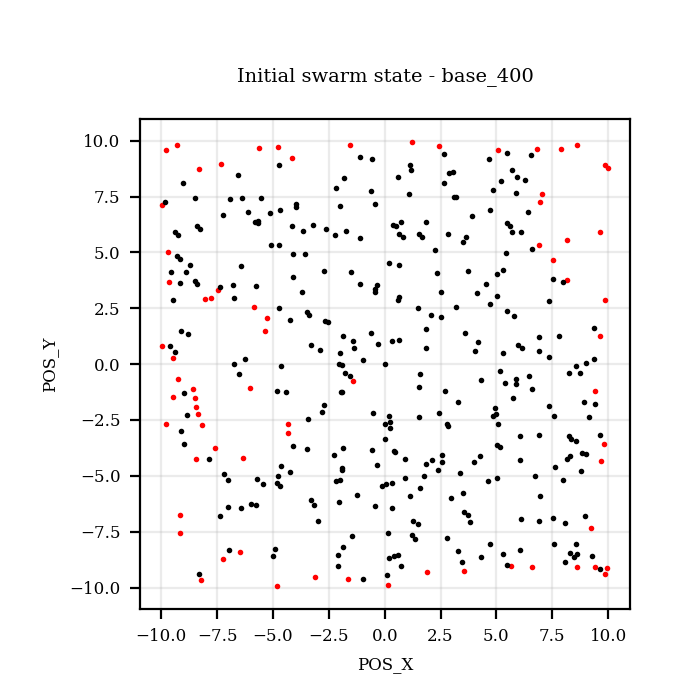

<AxesSubplot:title={'center':'Initial swarm state - base_400\n '}, xlabel='POS_X', ylabel='POS_Y'>

In [5]:
b, params = load_swarm('experiments/config/paper/base_400.json')
show_swarm(b, params, 'experiments/config/paper/base_400.json', 'Initial swarm state', saved_figure='fig/base_400_init.pdf')

Fig.3(b)

<IPython.core.display.Javascript object>


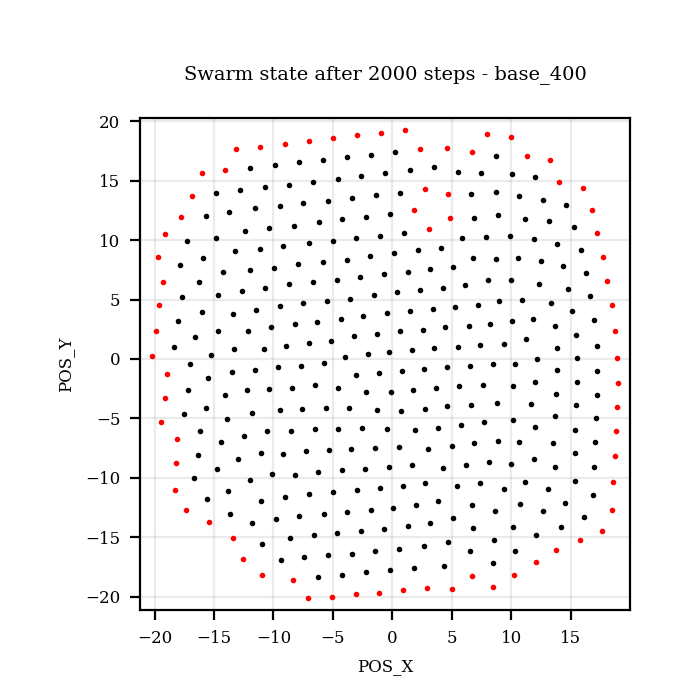

<AxesSubplot:title={'center':'Swarm state after 2000 steps - base_400\n '}, xlabel='POS_X', ylabel='POS_Y'>

In [6]:
run_simulation_for_n_steps(b, n_steps=2000, params=params)
show_swarm(b, params, 'experiments/config/paper/base_400.json', 'Swarm state after 2000 steps', saved_figure='fig/base_400_step_2000.pdf')

Fig.4(a)

<IPython.core.display.Javascript object>


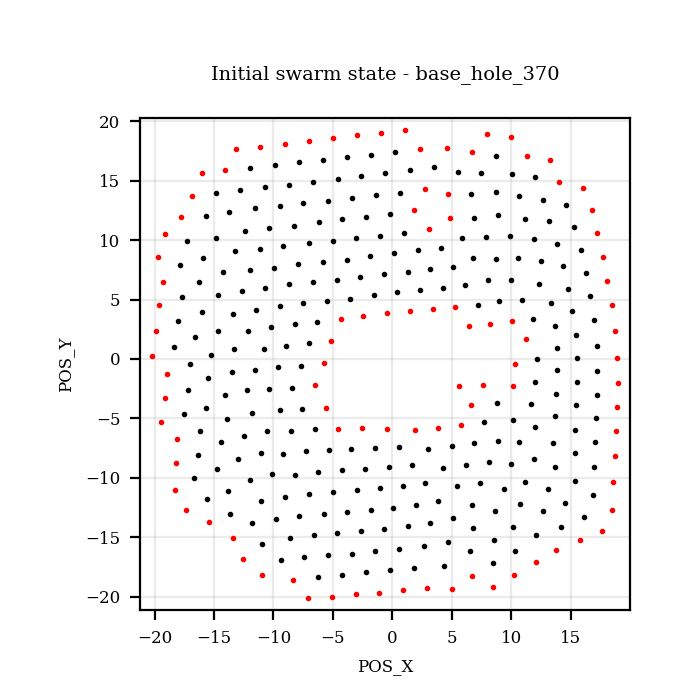

<AxesSubplot:title={'center':'Initial swarm state - base_hole_370\n '}, xlabel='POS_X', ylabel='POS_Y'>

In [7]:
b, params = load_swarm('experiments/config/paper/base_hole_370.json')
show_swarm(b, params, 'experiments/config/paper/base_hole_370.json', 'Initial swarm state', saved_figure='fig/base_hole_370_init.pdf')

Fig.4(b)

<IPython.core.display.Javascript object>


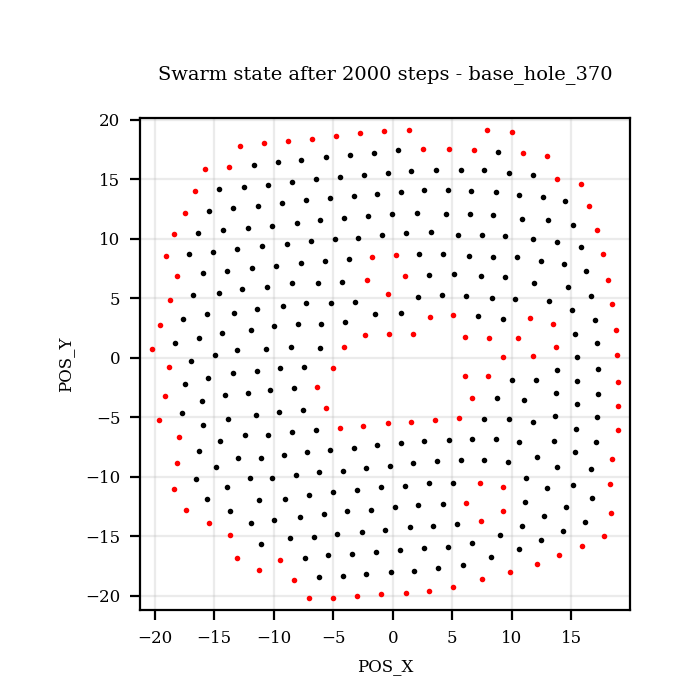

<AxesSubplot:title={'center':'Swarm state after 2000 steps - base_hole_370\n '}, xlabel='POS_X', ylabel='POS_Y'>

In [8]:
run_simulation_for_n_steps(b, n_steps=2000, params=params)
show_swarm(b, params, 'experiments/config/paper/base_hole_370.json', 'Swarm state after 2000 steps', saved_figure='fig/base_hole_370_step_2000.pdf')

Fig.4(c)

<IPython.core.display.Javascript object>


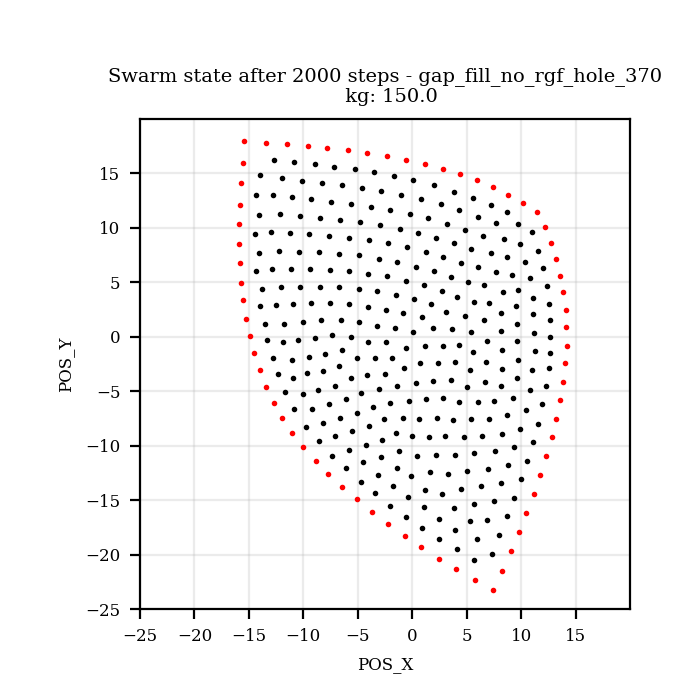

<AxesSubplot:title={'center':'Swarm state after 2000 steps - gap_fill_no_rgf_hole_370\n  kg: 150.0'}, xlabel='POS_X', ylabel='POS_Y'>

In [9]:
b, params = load_swarm('experiments/config/paper/gap_fill_no_rgf_hole_370.json')
run_simulation_for_n_steps(b, n_steps=2000, params=params)
show_swarm(b, params, 'experiments/config/paper/gap_fill_no_rgf_hole_370.json', 'Swarm state after 2000 steps', ax_min_max=[-25, 20, -25, 20], step=5, saved_figure='fig/gap_fill_no_rgf_hole_370_step_2000.pdf')

Fig.4(d)

<IPython.core.display.Javascript object>


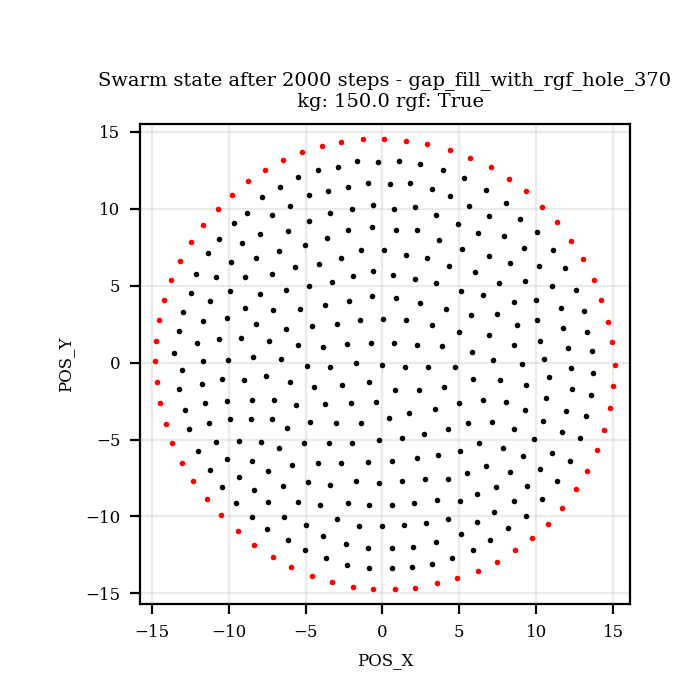

<AxesSubplot:title={'center':'Swarm state after 2000 steps - gap_fill_with_rgf_hole_370\n  kg: 150.0 rgf: True'}, xlabel='POS_X', ylabel='POS_Y'>

In [10]:
b, params = load_swarm('experiments/config/paper/gap_fill_with_rgf_hole_370.json')
run_simulation_for_n_steps(b, n_steps=2000, params=params)
show_swarm(b, params, 'experiments/config/paper/gap_fill_with_rgf_hole_370.json', 'Swarm state after 2000 steps', saved_figure='fig/gap_fill_with_rgf_hole_370_step_2000.pdf')

Fig.5(a)

<IPython.core.display.Javascript object>


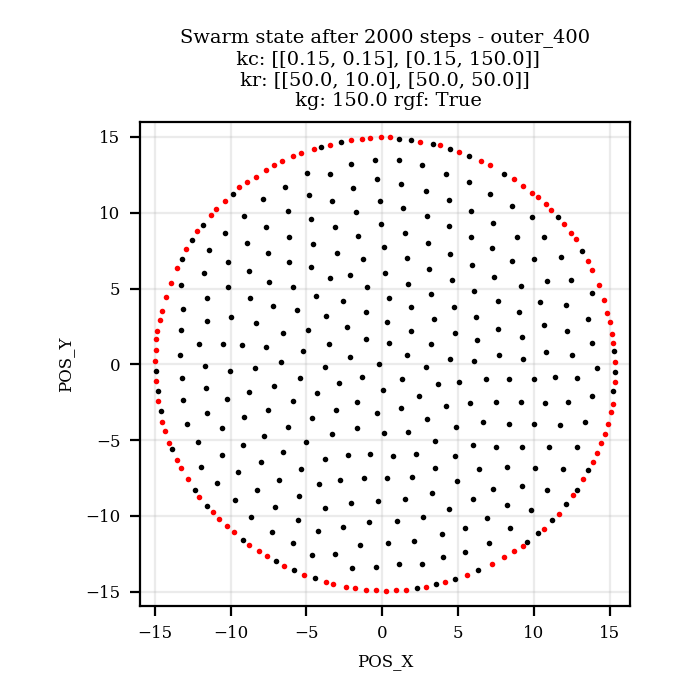

<AxesSubplot:title={'center':'Swarm state after 2000 steps - outer_400\n  kc: [[0.15, 0.15], [0.15, 150.0]] \n kr: [[50.0, 10.0], [50.0, 50.0]] \n kg: 150.0 rgf: True'}, xlabel='POS_X', ylabel='POS_Y'>

In [11]:
b, params = load_swarm('experiments/config/paper/outer_400.json')
run_simulation_for_n_steps(b, n_steps=2000, params=params)
show_swarm(b, params, 'experiments/config/paper/outer_400.json', 'Swarm state after 2000 steps', saved_figure='fig/outer_400_step_2000.pdf')

Fig.5(b)

<IPython.core.display.Javascript object>


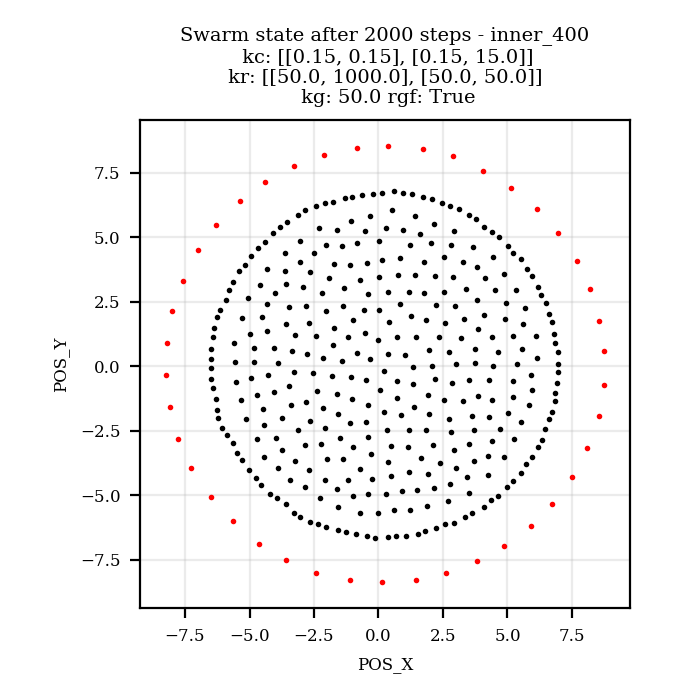

<AxesSubplot:title={'center':'Swarm state after 2000 steps - inner_400\n  kc: [[0.15, 0.15], [0.15, 15.0]] \n kr: [[50.0, 1000.0], [50.0, 50.0]] \n kg: 50.0 rgf: True'}, xlabel='POS_X', ylabel='POS_Y'>

In [12]:
b, params = load_swarm('experiments/config/paper/inner_400.json')
run_simulation_for_n_steps(b, n_steps=2000, params=params)
show_swarm(b, params, 'experiments/config/paper/inner_400.json', 'Swarm state after 2000 steps', saved_figure='fig/inner_400_step_2000.pdf')

Fig.6(a)

<IPython.core.display.Javascript object>


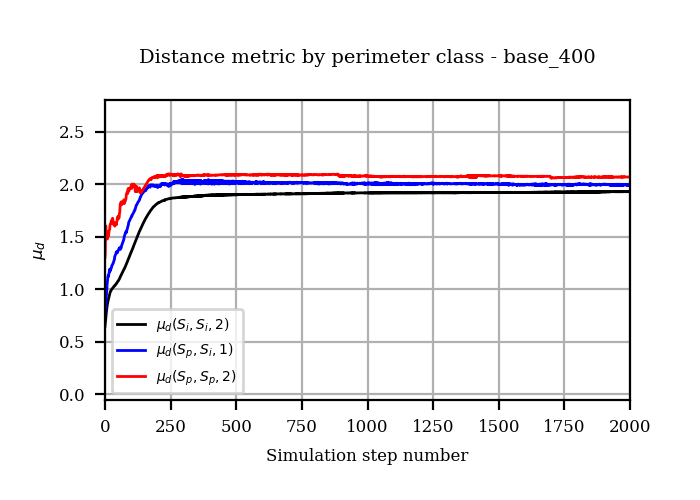

In [13]:
b, params, mean, stdevs = plot_k_mu_d_rel('experiments/config/paper/base_400.json', n_steps=2000, with_stdev=False, saved_figure='fig/base_400_d_2000.pdf')

Fig.6(b)

<IPython.core.display.Javascript object>


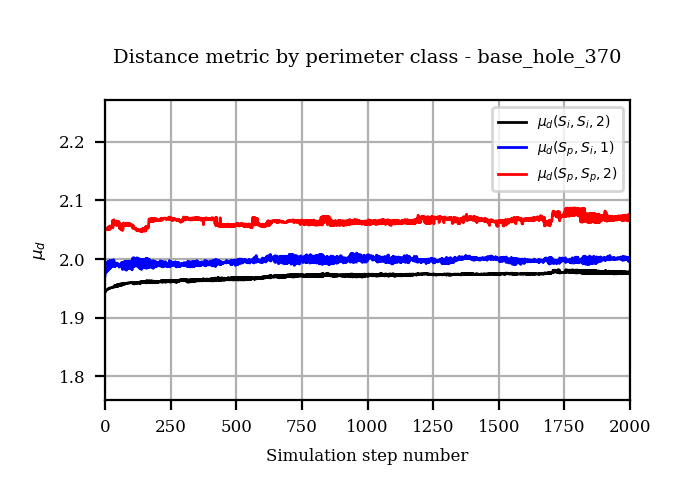

In [14]:
b, params, mean, stdevs = plot_k_mu_d_rel('experiments/config/paper/base_hole_370.json', n_steps=2000, with_stdev=False, saved_figure='fig/base_hole_370_d_2000.pdf')

Fig.6(c)

<IPython.core.display.Javascript object>


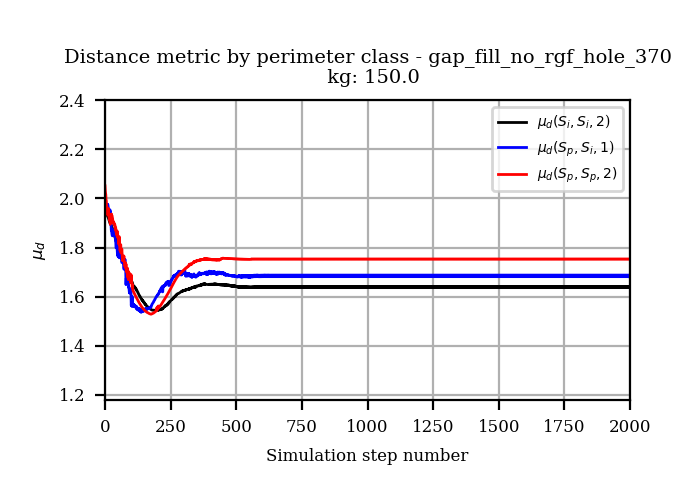

In [15]:
b, params, mean, stdevs = plot_k_mu_d_rel('experiments/config/paper/gap_fill_no_rgf_hole_370.json', n_steps=2000, with_stdev=False, saved_figure='fig/gap_fill_no_rgf_hole_370_d_2000.pdf')

Fig.6(d)

<IPython.core.display.Javascript object>


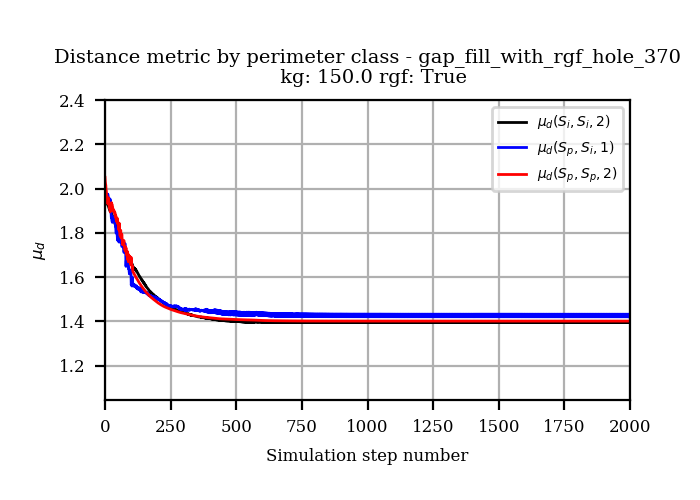

In [16]:
b, params, mean, stdevs = plot_k_mu_d_rel('experiments/config/paper/gap_fill_with_rgf_hole_370.json', n_steps=2000, with_stdev=False, saved_figure='fig/gap_fill_with_rgf_hole_370_d_2000.pdf')

Fig.7

<IPython.core.display.Javascript object>


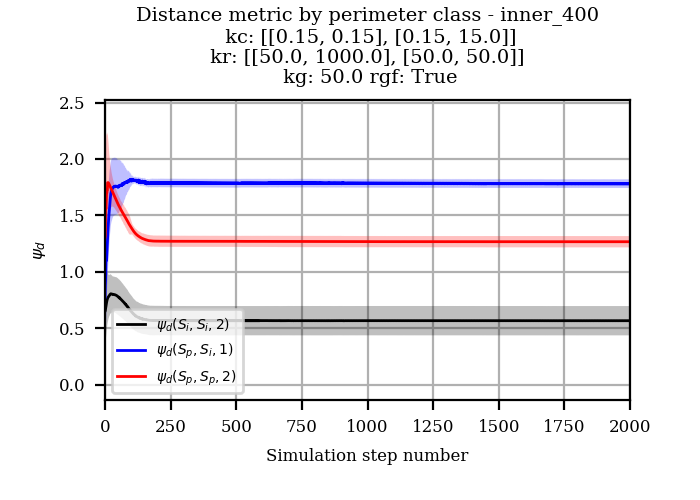

In [17]:
b, params, mean, stdevs = plot_k_mu_d_rel('experiments/config/paper/inner_400.json', n_steps=2000, with_stdev=True, saved_figure='fig/inner_400_ds_2000.pdf')

Fig.8(a)

<IPython.core.display.Javascript object>


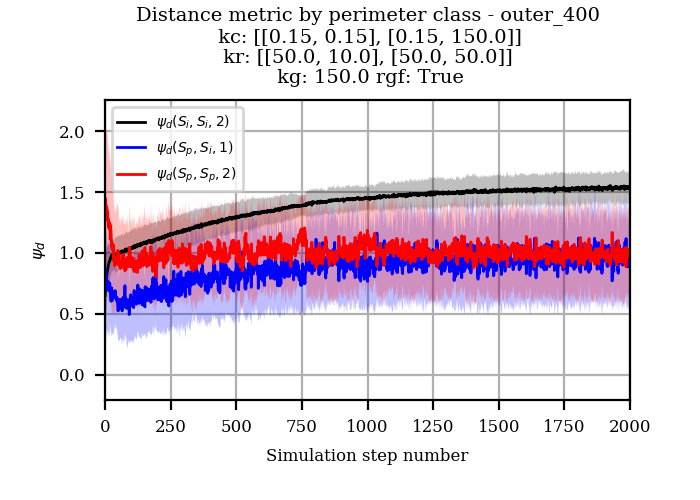

In [18]:
b, params, mean, stdevs = plot_k_mu_d_rel('experiments/config/paper/outer_400.json', n_steps=2000, with_stdev=True, saved_figure='fig/outer_400_ds_2000.pdf')

Fig.8(b)

<IPython.core.display.Javascript object>


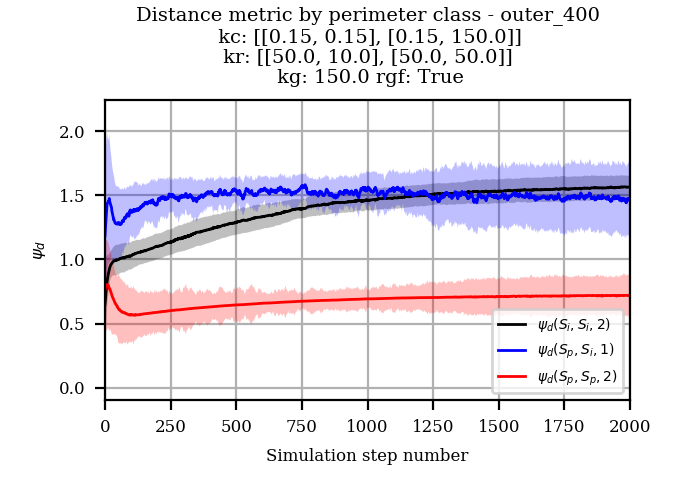

In [19]:
a, p = agent_perimeter_status(config_file='experiments/config/paper/outer_400.json')
b, params, mean, stdevs = plot_k_mu_d_rel('experiments/config/paper/outer_400.json', n_steps=2000, pre_p=p, with_stdev=True, saved_figure='fig/outer_400_ds_pre_p_2000.pdf')